In [2]:
import sklearn.svm as sk
import sklearn.metrics as metrics
import sklearn.decomposition as decomp
import sklearn.preprocessing as preproc
import sklearn.pipeline as skp
import sklearn.model_selection as skmodel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df_main = pd.read_csv(r'data\features_canon.csv')

In [4]:
df_main.set_index("index", inplace = True)

In [5]:
df_main = df_main.replace(np.nan, 0)

In [6]:
2960-296

2664

In [82]:
df_train = df_main.head(2664)
df_test = df_main.tail(296)

In [3]:
# Following function from Aneesha Bakharia
# https://aneesha.medium.com/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

def plot_coefficients(coefs, feature_names, current_class, top_features=20):
    top_positive_coefficients = np.argsort(coefs)[-top_features:]
    top_negative_coefficients = np.argsort(coefs)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coefs[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coefs[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title("Coefficients for canonicity")
    plt.savefig('img/coefs_canonicity.png')
    # TODO: write them to disk as CSV files

In [20]:
def train_svm(train, test, cross_validate=None, k=10, dim_reduc=None, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False):
    """
    Function to train svm
    :param train: train data... (in panda dataframe)
    :param test: test data (itou)
    :param cross_validate: whether or not to perform cross validation (possible values: leave-one-out and k-fold)
    :param k: k parameter for k-fold cross validation
    :param dim_reduc: dimensionality reduction of input data. Implemented values are pca and som.
    :param norms: perform normalisations, i.e. z-scores and L2 (default True)
    :param kernel: kernel for SVM
    :param final_pred: do the final predictions?
    :param get_coefs, if true, writes to disk (coefficients.csv) and plots the most important coefficients for each class
    :return: returns a pipeline with a fitted svm model, and if possible prints evaluation and writes to disk:
    confusion_matrix.csv, misattributions.csv and (if required) FINAL_PREDICTIONS.csv
    """

    print(".......... Formatting data ........")
    # Save the classes
    classes = list(train.canon)
    train = train.drop(['canon'], axis=1)

    if test is not None:
        #classes_test = list(test.loc[:, 'author'])
        classes_test = list(test.canon) 
        test = test.drop(['canon'], axis=1)
        preds_index = list(test.index)

    nfeats = train.columns.__len__()

    # CREATING PIPELINE
    print(".......... Creating pipeline according to user choices ........")
    estimators = []

    if norms:
        # Z-scores
        # TODO: me suis embeté à implémenter quelque chose qui existe
        # déjà via sklearn.preprocessing.StandardScaler()
        print(".......... using normalisations ........")
        estimators.append(('scaler', preproc.StandardScaler()))
        # NB: j'utilise le built-in
        # normalisation L2
        # cf. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer

        estimators.append(('normalizer', preproc.Normalizer()))

    print(".......... choosing SVM ........")

    if kernel == "LinearSVC":
        # try a faster one
        estimators.append(('model', sk.LinearSVC()))
        # classif = sk.LinearSVC()

    else:
        estimators.append(('model', sk.SVC(kernel=kernel)))
        # classif = sk.SVC(kernel=kernel)

    print(".......... Creating pipeline with steps ........")
    print(estimators)
    pipe = skp.Pipeline(estimators)
    
    
    
    if cross_validate is not None:
        if cross_validate == 'leave-one-out':
            myCV = skmodel.LeaveOneOut()

        if cross_validate == 'k-fold':
            myCV = skmodel.KFold(n_splits=k)

        print(".......... "+ cross_validate +" cross validation will be performed ........")
        print(".......... using " + str(myCV.get_n_splits(train)) + " samples ........")

        # Will need to
        # 1. train a model
        # 2. get prediction
        # 3. compute score: precision, recall, F1 for all categories

        preds = skmodel.cross_val_predict(pipe, train, classes, cv=myCV, verbose=1, n_jobs=-1)
        cv_results = skmodel.cross_validate(pipe, train, classes, cv=myCV, verbose=1, n_jobs=-1)

        # and now, leave one out evaluation (very small redundancy here, one line that could be stored elsewhere)
        unique_labels = list(set(classes))
        pd.DataFrame(metrics.confusion_matrix(classes, preds, labels=unique_labels),
                         index=['true:{:}'.format(x) for x in unique_labels],
                         columns=['pred:{:}'.format(x) for x in unique_labels]).to_csv("confusion_matrix.csv")

        print(metrics.classification_report(classes, preds))
        # writing misattributions
        pd.DataFrame([i for i in zip(list(train.index), list(classes), list(preds)) if i[1] != i[2] ],
                         columns=["id", "True", "Pred"]
                         ).set_index('id').to_csv("misattributions.csv")

        # and now making the model for final preds after leave one out if necessary
        if final_pred or get_coefs:
            print(".......... Training final SVM with all train set ........")
            pipe.fit(train, classes)

        if final_pred:
            preds = pipe.predict(test)
    
        return pipe, cv_results
    
    # And now the simple case where there is only one svm to train
    else:
        pipe.fit(train, classes)
        preds = pipe.predict(test)
        # and evaluate
        unique_labels = list(set(classes + classes_test))

        pd.DataFrame(metrics.confusion_matrix(classes_test, preds, labels=unique_labels),
                         index=['true:{:}'.format(x) for x in unique_labels],
                         columns=['pred:{:}'.format(x) for x in unique_labels]).to_csv("confusion_matrix.csv")

        print(metrics.classification_report(classes_test, preds))

    # AND NOW, we need to evaluate or create the final predictions
    if final_pred:
        print(".......... Writing final predictions to FINAL_PREDICTIONS.csv ........")
        # Get the decision function too
        myclasses = pipe.classes_
        decs = pipe.decision_function(test)
        #######ERROR --- resolu
        dists = {}
        dists["canon"] = decs

        pd.DataFrame(data={**{'filename': preds_index, 'non-canon': list(preds)}, **dists}).to_csv("FINAL_PREDICTIONS.csv")


    if get_coefs:
        print("..........   Get Coef    ..........")
        # For “one-vs-rest” LinearSVC the attributes coef_ and intercept_ have the shape (n_classes, n_features) and
        # (n_classes,) respectively.
        # Each row of the coefficients corresponds to one of the n_classes “one-vs-rest” classifiers and similar for the
        # intercepts, in the order of the “one” class.
        # Save coefficients for the last model
        
        #####ERROR    --- pipe.named_steps['model'].coef_  --- resolu
        pd.DataFrame(pipe.named_steps['model'].coef_,
                         index=['non-canon'],
                         columns=train.columns).to_csv("coefficients.csv")

        # TODO: optionalise  the number of top_features… ?
        plot_coefficients(pipe.named_steps['model'].coef_[0], train.columns, str(pipe.classes_[0]))

    return pipe

### Cross-Validation Size-Opti novel metadata

In [5]:
df_size_opti = pd.read_csv(r'data\df_size_opti.csv')
df_size_opti.set_index("index", inplace = True)
df_size_opti = df_size_opti.replace(np.nan, 0)
len(df_size_opti)

640

In [6]:
print(df_size_opti['canon'].value_counts(normalize=True))
print(df_size_opti['canon'].value_counts())

non_canon    0.592187
canon        0.407813
Name: canon, dtype: float64
non_canon    379
canon        261
Name: canon, dtype: int64


In [14]:
df_train_size_opti = df_size_opti.head(576)
df_test_size_opti = df_size_opti.tail(64)

In [21]:
pipe_novel_CV, scores_novel_CV = train_svm(df_train_size_opti, df_test_size_opti, cross_validate='k-fold')

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
.......... k-fold cross validation will be performed ........
.......... using 10 samples ........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.9s finished


              precision    recall  f1-score   support

       canon       0.69      0.70      0.69       241
   non_canon       0.78      0.77      0.78       335

    accuracy                           0.74       576
   macro avg       0.73      0.74      0.73       576
weighted avg       0.74      0.74      0.74       576



In [22]:
scores_novel_CV

{'fit_time': array([1.00507188, 1.0530746 , 0.98407316, 1.0110724 , 0.97207212,
        0.91806912, 0.92006636, 0.92006874, 0.7500577 , 0.74305415]),
 'score_time': array([0.081007  , 0.08800721, 0.0940063 , 0.08601117, 0.08300924,
        0.07300425, 0.0780108 , 0.1020093 , 0.06000447, 0.05600786]),
 'test_score': array([0.68965517, 0.75862069, 0.77586207, 0.68965517, 0.67241379,
        0.75862069, 0.75438596, 0.70175439, 0.75438596, 0.85964912])}

In [23]:
sum(scores_novel_CV['test_score'])/len(scores_novel_CV['test_score'])

0.7415003024803388

### Cross-Validation author metadata

In [24]:
df_fabula = pd.read_csv(r'data\features_fabula.csv', index_col='index')
df_fabula = df_fabula.replace(np.nan, 0)

In [25]:
print(df_fabula['canon'].value_counts(normalize=True))
print(df_fabula['canon'].value_counts())

False    0.609797
True     0.390203
Name: canon, dtype: float64
False    1805
True     1155
Name: canon, dtype: int64


In [28]:
len(df_fabula)

2960

In [38]:
df_train_author_CV = df_fabula.head(2660)
df_test_author_CV = df_fabula.tail(300)

In [39]:
pipe_fabula, scores_author_CV = train_svm(df_train_author_CV, df_test_author_CV, cross_validate='k-fold')

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
.......... k-fold cross validation will be performed ........
.......... using 10 samples ........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.8s finished


              precision    recall  f1-score   support

       False       0.90      0.92      0.91      1628
        True       0.87      0.85      0.86      1032

    accuracy                           0.89      2660
   macro avg       0.89      0.88      0.89      2660
weighted avg       0.89      0.89      0.89      2660



In [40]:
scores_author_CV

{'fit_time': array([5.03738546, 6.41848707, 5.6714263 , 5.01037908, 5.37040734,
        5.43940902, 5.550421  , 5.85143781, 3.25924349, 3.25624442]),
 'score_time': array([1.26509261, 0.53003693, 0.16801572, 1.09708428, 0.27802587,
        0.14401221, 0.12801266, 0.27602291, 0.0790062 , 0.07400608]),
 'test_score': array([0.86466165, 0.93984962, 0.87593985, 0.89097744, 0.87969925,
        0.88721805, 0.91729323, 0.87969925, 0.91729323, 0.86090226])}

In [41]:
sum(scores_author_CV['test_score'])/len(scores_author_CV['test_score'])

0.8913533834586467

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       canon       0.55      0.17      0.26        36
   non_canon       0.89      0.98      0.94       260

    accuracy                           0.88       296
   macro avg       0.72      0.57      0.60       296
weighted avg       0.85      0.88      0.85       296

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


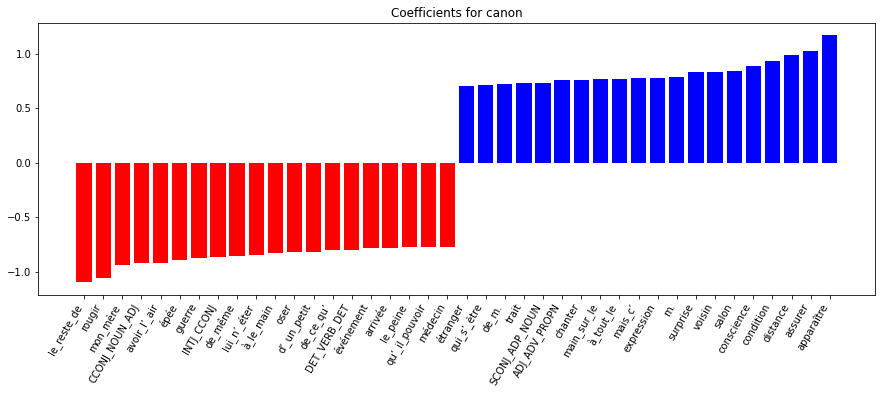

In [9]:
svm_1 = train_svm(df_train, df_test, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [4]:
df_main_temp = pd.read_csv(r'data\features_fabula.csv')

In [165]:
df_main_metadata = pd.read_csv(r'data\df_main_author.csv')

In [179]:
df_main_metadata

,le,de,un,et,il,avoir,à,lui,être,son,...,PROPN_VERB_AUX,VERB_CCONJ_CCONJ,ADV_NOUN_AUX,SCONJ_NOUN_AUX,PRON_ADJ_AUX,SCONJ_PROPN_DET,ADV_DET_DET,ADV_CCONJ_PROPN,VERB_VERB_AUX,canon
index,,,,,,,,,,,,,,,,,,,,,
1869_Feval-Paul_Maman-Leo-Les-habits-Noirs_Tome-V,0.063060,0.046097,0.023424,0.021860,0.018918,0.024339,0.016387,0.012571,0.016675,0.013939,...,0.000134,0.000010,0.000051,0.000021,0.000051,0.000010,0.000041,0.000093,0.000031,True
1865_Maricourt-Rene-Du-Mesnil_Donatien,0.061108,0.050939,0.031604,0.019637,0.020051,0.017887,0.018078,0.014418,0.011665,0.015404,...,0.000016,0.000032,0.000000,0.000032,0.000048,0.000000,0.000016,0.000000,0.000032,False
1998_Darrieussecq-Marie_Naissance-des-fantomes,0.067883,0.056454,0.032576,0.023217,0.008819,0.017158,0.018808,0.006569,0.005729,0.010109,...,0.000030,0.000030,0.000000,0.000000,0.000030,0.000000,0.000030,0.000000,0.000000,True
1884_Chavette-Eugene_Le-saucisson-a-pattes_II-Le-plan-de-Cardeuc,0.076659,0.059018,0.022950,0.013403,0.024227,0.022991,0.022950,0.013947,0.010701,0.014924,...,0.000068,0.000000,0.000054,0.000068,0.000041,0.000014,0.000027,0.000068,0.000054,False
1910_Ivoi-Paul-d-_Millionnaire-malgre-lui_tome-2,0.068457,0.052986,0.028188,0.017413,0.015869,0.019100,0.018129,0.012288,0.013481,0.011571,...,0.000016,0.000048,0.000096,0.000000,0.000048,0.000016,0.000080,0.000016,0.000048,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1889_Coppee-François_Henriette,0.056222,0.052269,0.027711,0.026779,0.015721,0.017986,0.018208,0.031308,0.012257,0.022782,...,0.000044,0.000089,0.000044,0.000044,0.000000,0.000044,0.000044,0.000044,0.000000,False
1885_Lermina-Jules_Histoires-incroyables,0.053957,0.042729,0.028048,0.019481,0.021110,0.021620,0.019198,0.009686,0.018699,0.010837,...,0.000033,0.000065,0.000033,0.000054,0.000043,0.000033,0.000065,0.000033,0.000076,False
1843_Sue-Eugene_Les-Mysteres-de-Paris_Tome-IV,0.051923,0.048799,0.024148,0.020082,0.017739,0.020243,0.019579,0.009866,0.018421,0.012173,...,0.000072,0.000108,0.000054,0.000036,0.000045,0.000045,0.000063,0.000054,0.000027,False


In [167]:
df_main_metadata.set_index("index", inplace = True)
df_main_metadata = df_main_metadata.replace(np.nan, 0)

In [168]:
df_master = df_main_metadata.iloc[:,:300].merge(df_main_metadata.iloc[:,1000:2300], on='index', how='left')

In [169]:
df_master

,le,de,un,et,il,avoir,à,lui,être,son,...,-ce_que_vous,que_je_vouloir,bien_qu’_il,j’_avoir_faire,de_ce_que,milieu_de_le,le_tête_et,m’_avoir_dire,d’_un_coup,le_bras_de
index,,,,,,,,,,,,,,,,,,,,,
1869_Feval-Paul_Maman-Leo-Les-habits-Noirs_Tome-V,0.063060,0.046097,0.023424,0.021860,0.018918,0.024339,0.016387,0.012571,0.016675,0.013939,...,0.000113,0.000082,0.000103,0.000134,0.000051,0.000072,0.000051,0.000154,0.000031,0.000062
1865_Maricourt-Rene-Du-Mesnil_Donatien,0.061108,0.050939,0.031604,0.019637,0.020051,0.017887,0.018078,0.014418,0.011665,0.015404,...,0.000048,0.000127,0.000111,0.000048,0.000048,0.000032,0.000032,0.000048,0.000048,0.000000
1998_Darrieussecq-Marie_Naissance-des-fantomes,0.067883,0.056454,0.032576,0.023217,0.008819,0.017158,0.018808,0.006569,0.005729,0.010109,...,0.000030,0.000000,0.000000,0.000150,0.000060,0.000030,0.000000,0.000030,0.000360,0.000060
1884_Chavette-Eugene_Le-saucisson-a-pattes_II-Le-plan-de-Cardeuc,0.076659,0.059018,0.022950,0.013403,0.024227,0.022991,0.022950,0.013947,0.010701,0.014924,...,0.000054,0.000000,0.000000,0.000000,0.000068,0.000014,0.000054,0.000000,0.000000,0.000027
1910_Ivoi-Paul-d-_Millionnaire-malgre-lui_tome-2,0.068457,0.052986,0.028188,0.017413,0.015869,0.019100,0.018129,0.012288,0.013481,0.011571,...,0.000064,0.000048,0.000080,0.000080,0.000048,0.000048,0.000000,0.000016,0.000016,0.000080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1889_Coppee-François_Henriette,0.056222,0.052269,0.027711,0.026779,0.015721,0.017986,0.018208,0.031308,0.012257,0.022782,...,0.000044,0.000044,0.000044,0.000000,0.000044,0.000089,0.000000,0.000044,0.000089,0.000044
1885_Lermina-Jules_Histoires-incroyables,0.053957,0.042729,0.028048,0.019481,0.021110,0.021620,0.019198,0.009686,0.018699,0.010837,...,0.000022,0.000109,0.000054,0.000043,0.000109,0.000065,0.000054,0.000054,0.000033,0.000011
1843_Sue-Eugene_Les-Mysteres-de-Paris_Tome-IV,0.051923,0.048799,0.024148,0.020082,0.017739,0.020243,0.019579,0.009866,0.018421,0.012173,...,0.000045,0.000036,0.000135,0.000063,0.000081,0.000045,0.000018,0.000233,0.000072,0.000045


In [174]:
df_master["canon"]=df_main_metadata["canon"]
df_train_master = df_master.head(2664)
df_test_master = df_master.tail(296)

In [182]:
svm_test = train_svm(df_train_master, df_test_master, norms=True, kernel="LinearSVC", cross_validate='k-fold', final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
.......... k-fold cross validation will be performed ........
.......... using 10 samples ........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.3s finished


              precision    recall  f1-score   support

       False       0.85      0.87      0.86      1328
        True       0.80      0.77      0.78       872

    accuracy                           0.83      2200
   macro avg       0.83      0.82      0.82      2200
weighted avg       0.83      0.83      0.83      2200



.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.97      0.98      0.97       178
        True       0.97      0.95      0.96       118

    accuracy                           0.97       296
   macro avg       0.97      0.96      0.96       296
weighted avg       0.97      0.97      0.97       296

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


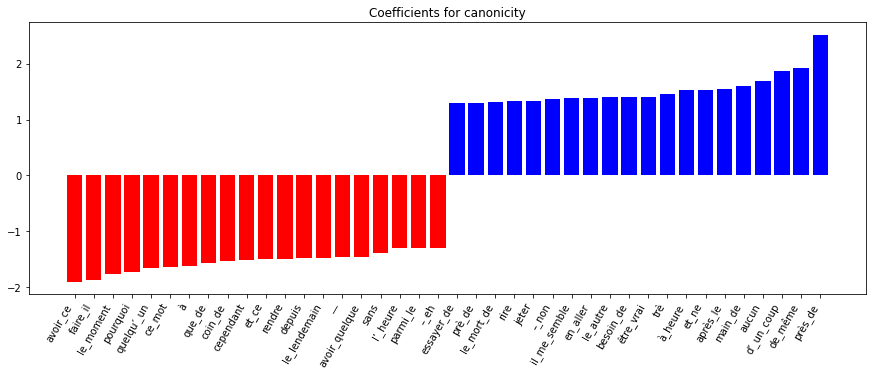

In [175]:
svm_test = train_svm(df_train_master, df_test_master, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

### AVEC df_master["canon"]=features_fabula["canon"]

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.99      0.96      0.97       158
        True       0.96      0.99      0.97       138

    accuracy                           0.97       296
   macro avg       0.97      0.97      0.97       296
weighted avg       0.97      0.97      0.97       296

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


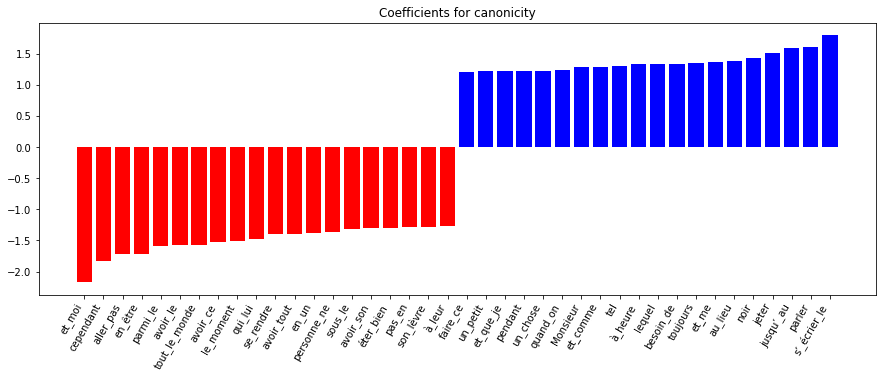

In [173]:
svm_test = train_svm(df_train_master, df_test_master, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [ ]:
#rbf 94% accuracy

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.93      0.93      0.93       174
        True       0.90      0.89      0.90       122

    accuracy                           0.92       296
   macro avg       0.91      0.91      0.91       296
weighted avg       0.92      0.92      0.92       296

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


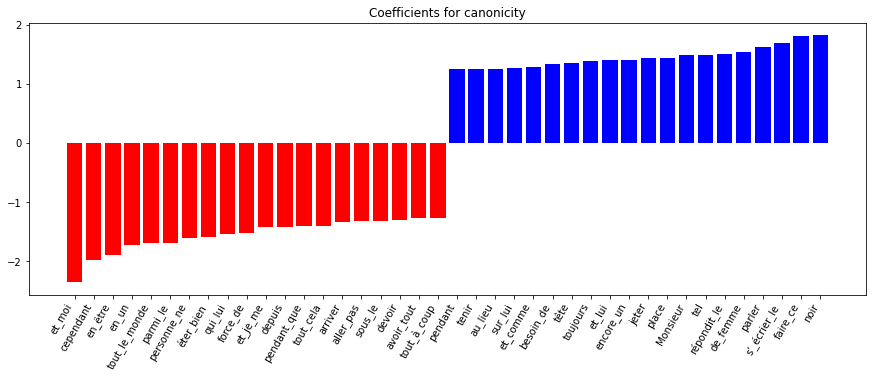

In [164]:
svm_test = train_svm(df_train_master, df_test_master, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [69]:
df_main_loc = df_main_temp.iloc[:, 1000:2200]

In [70]:
df_main_loc["canon"]=df_main_temp["canon"]

In [49]:
df_main_loc.index=df_main_temp.index

In [50]:
df_main_loc = df_main_loc.replace(np.nan, 0)

In [71]:
df_train_loc = df_main_loc.head(2664)
df_test_loc = df_main_loc.tail(296)

In [72]:
svm_test = train_svm(df_train_loc, df_test_loc, norms=True, kernel="rbf", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', SVC())]
              precision    recall  f1-score   support

       False       0.93      0.97      0.95       174
        True       0.95      0.89      0.92       122

    accuracy                           0.94       296
   macro avg       0.94      0.93      0.93       296
weighted avg       0.94      0.94      0.94       296



In [6]:
df_main_temp.set_index("index", inplace = True)
df_main_temp = df_main_temp.replace(np.nan, 0)

In [7]:
df_train_temp = df_main_temp.head(2664)
df_test_temp = df_main_temp.tail(296)

In [8]:
len(list(df_test_temp["canon"]))

296

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.91      0.92      0.92       174
        True       0.88      0.88      0.88       122

    accuracy                           0.90       296
   macro avg       0.90      0.90      0.90       296
weighted avg       0.90      0.90      0.90       296

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


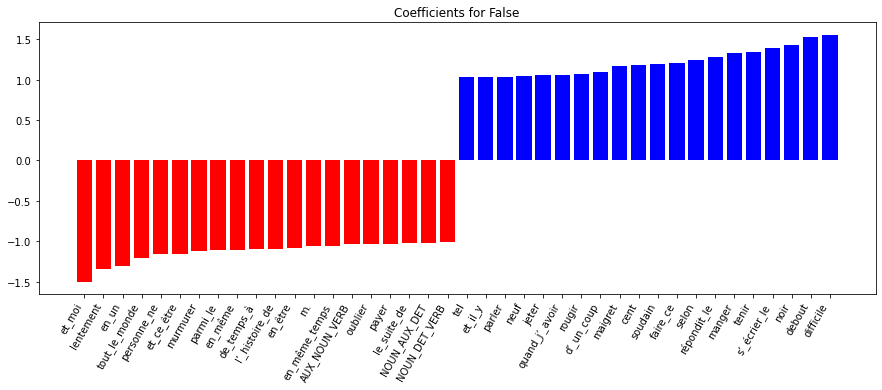

In [9]:
svm_test = train_svm(df_train_temp, df_test_temp, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [10]:
svm_test = train_svm(df_train_temp, df_test_temp, norms=True, kernel="rbf", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', SVC())]
              precision    recall  f1-score   support

       False       0.91      0.94      0.93       174
        True       0.91      0.87      0.89       122

    accuracy                           0.91       296
   macro avg       0.91      0.91      0.91       296
weighted avg       0.91      0.91      0.91       296



.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
.......... k-fold cross validation will be performed ........
.......... using 10 samples ........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   57.0s finished


              precision    recall  f1-score   support

       False       0.90      0.92      0.91      1631
        True       0.87      0.84      0.86      1033

    accuracy                           0.89      2664
   macro avg       0.89      0.88      0.89      2664
weighted avg       0.89      0.89      0.89      2664

.......... Training final SVM with all train set ........
.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


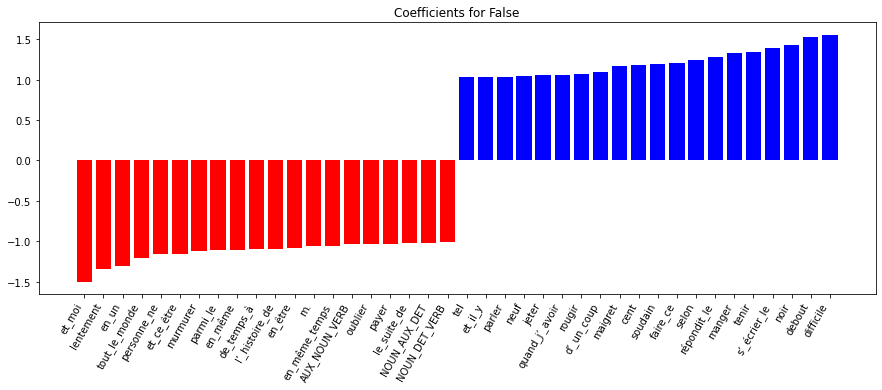

In [42]:
svm_cross_validated_fabula = train_svm(df_train_temp, df_test_temp, cross_validate='k-fold', norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [131]:
df_fabula_100 = df_main_temp.iloc[:, 0:100]

In [132]:
df_fabula_100['canon'] = df_main_temp['canon']

In [163]:
df_fabula_train = df_fabula_100.head(2664)
df_fabula_test = df_fabula_100.tail(296)

In [145]:
svm_fabula_100 = train_svm(df_fabula_train, df_fabula_test, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.86      0.85      0.86       174
        True       0.79      0.80      0.80       122

    accuracy                           0.83       296
   macro avg       0.83      0.83      0.83       296
weighted avg       0.83      0.83      0.83       296



In [137]:
df_fabula_1000 = df_main_temp.iloc[:, 0:1000]

In [138]:
df_fabula_1000['canon'] = df_main_temp['canon']

In [159]:
df_fabula_train = df_fabula_1000.head(2664)
df_fabula_test = df_fabula_1000.tail(296)

In [141]:
svm_fabula_1000 = train_svm(df_fabula_train, df_fabula_test, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.90      0.92      0.91       174
        True       0.88      0.86      0.87       122

    accuracy                           0.90       296
   macro avg       0.89      0.89      0.89       296
weighted avg       0.90      0.90      0.90       296



In [43]:
import random

In [44]:
random_list = [bool(random.getrandbits(1)) for i in range(2960)]

In [45]:
df_main_temp["canon"] = random_list

In [46]:
df_train_rand = df_main_temp.head(2664)
df_test_rand = df_main_temp.tail(296)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.55      0.55      0.55       146
        True       0.56      0.56      0.56       150

    accuracy                           0.55       296
   macro avg       0.55      0.55      0.55       296
weighted avg       0.55      0.55      0.55       296

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


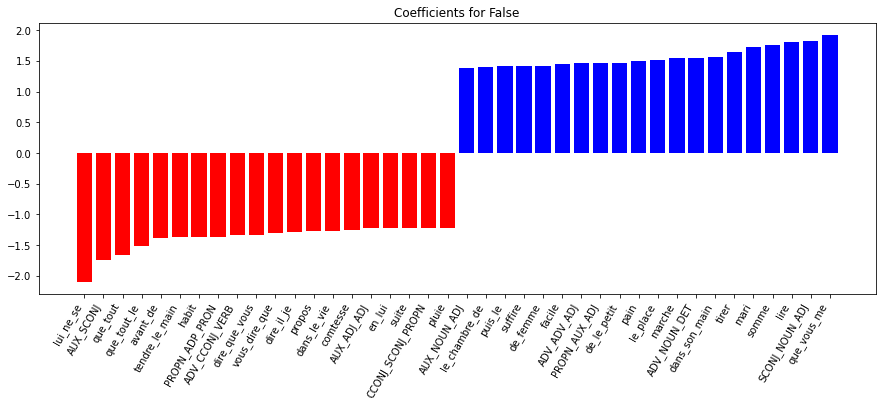

In [47]:
svm_3 = train_svm(df_train_rand, df_test_rand, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [19]:
df_fabula_ones = pd.read_csv(r'data\df_fabula_ones.csv')
df_fabula_ones.set_index("Unnamed: 0", inplace = True)
df_fabula_ones = df_fabula_ones.replace(np.nan, 0)

In [20]:
len(df_fabula_ones)

394

In [22]:
df_fabula_ones_train = df_main_temp.head(354)
df_fabula_ones_test = df_main_temp.tail(40)

In [25]:
svm_ones = train_svm(df_fabula_ones_train, df_fabula_ones_test, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.93      0.93      0.93        28
        True       0.83      0.83      0.83        12

    accuracy                           0.90        40
   macro avg       0.88      0.88      0.88        40
weighted avg       0.90      0.90      0.90        40



In [26]:
df_test = pd.read_csv(r'data/df_main_author.csv')
df_test.set_index("index", inplace = True)
df_test = df_test.replace(np.nan, 0)

In [27]:
len(df_test)

2200

In [28]:
df_train_test = df_main_balanced.head(1980)
df_test_test = df_main_balanced.tail(220)

In [30]:
svm_4 = train_svm(df_train_balanced, df_test_balanced, norms=True, kernel="rbf", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', SVC())]
              precision    recall  f1-score   support

       canon       0.83      0.83      0.83        30
   non_canon       0.77      0.77      0.77        22

    accuracy                           0.81        52
   macro avg       0.80      0.80      0.80        52
weighted avg       0.81      0.81      0.81        52



In [4]:
df_main_balanced = pd.read_csv(r'data\features_balanced.csv')
df_main_balanced.set_index("index", inplace = True)
df_main_balanced = df_main_balanced.replace(np.nan, 0)

In [5]:
df_train_balanced = df_main_balanced.head(470)
df_test_balanced = df_main_balanced.tail(52)

In [18]:
svm_4 = train_svm(df_train_balanced, df_test_balanced, norms=True, kernel="rbf", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', SVC())]
              precision    recall  f1-score   support

       canon       0.83      0.83      0.83        30
   non_canon       0.77      0.77      0.77        22

    accuracy                           0.81        52
   macro avg       0.80      0.80      0.80        52
weighted avg       0.81      0.81      0.81        52



.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       canon       0.81      0.83      0.82        30
   non_canon       0.76      0.73      0.74        22

    accuracy                           0.79        52
   macro avg       0.78      0.78      0.78        52
weighted avg       0.79      0.79      0.79        52

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


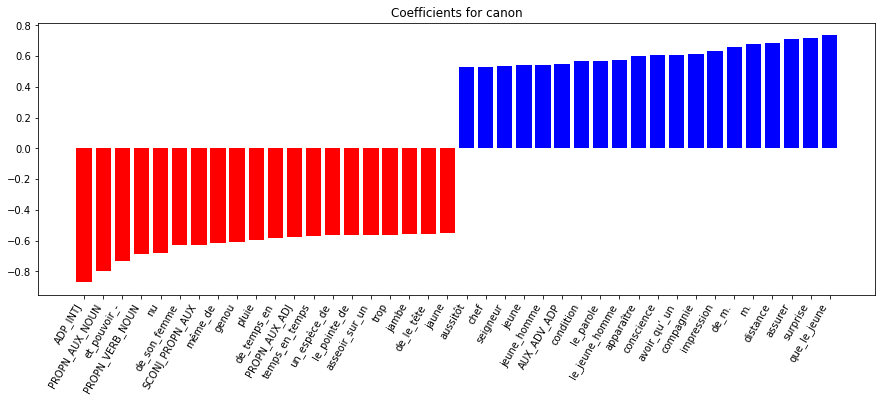

In [30]:
svm_4 = train_svm(df_train_balanced, df_test_balanced, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [7]:
svm_cross_validated = train_svm(df_train_balanced, df_test_balanced, cross_validate='k-fold', norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
.......... k-fold cross validation will be performed ........
.......... using 10 samples ........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.3s finished


              precision    recall  f1-score   support

       canon       0.69      0.76      0.72       231
   non_canon       0.74      0.67      0.70       239

    accuracy                           0.71       470
   macro avg       0.72      0.71      0.71       470
weighted avg       0.72      0.71      0.71       470



In [146]:
df_main_balanced_unigram = pd.read_csv(r'data\features_balanced_unigram.csv')
df_main_balanced_unigram.set_index("index", inplace = True)
df_main_balanced_unigram = df_main_balanced_unigram.replace(np.nan, 0)

In [147]:
df_main_balanced_unigram.set_index("index", inplace = True)

In [148]:
df_main_balanced_unigram = df_main_balanced_unigram.replace(np.nan, 0)

In [149]:
df_train_balanced_unigram = df_main_balanced_unigram.head(470)
df_test_balanced_unigram = df_main_balanced_unigram.tail(52)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       canon       0.79      0.73      0.76        30
   non_canon       0.67      0.73      0.70        22

    accuracy                           0.73        52
   macro avg       0.73      0.73      0.73        52
weighted avg       0.74      0.73      0.73        52

.......... Writing final predictions to FINAL_PREDICTIONS.csv ........
..........   Get Coef    ..........


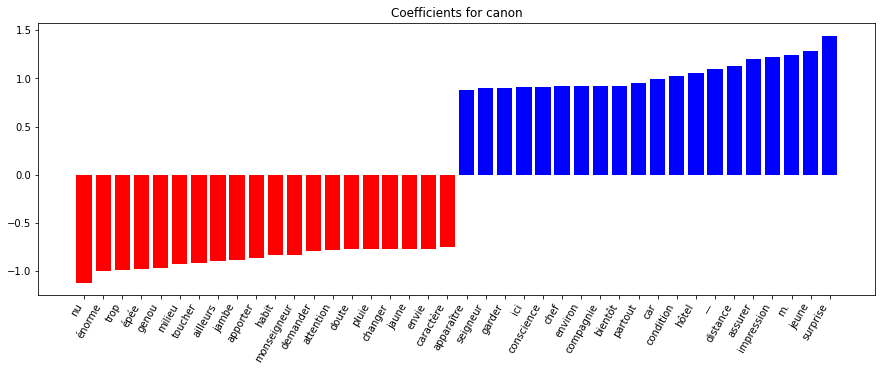

In [150]:
svm_5 = train_svm(df_train_balanced_unigram, df_test_balanced_unigram, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [37]:
df_100_most_common_unigrams = df_main_balanced_unigram.iloc[:, 0:100]

In [38]:
df_100_most_common_unigrams['canon'] = df_main_balanced_unigram['canon']

In [39]:
df_train_balanced_100_most_common_unigrams = df_100_most_common_unigrams.head(470)
df_test_balanced_100_most_common_unigrams = df_100_most_common_unigrams.tail(52)

In [40]:
list_100_mots = list(df_train_balanced_100_most_common_unigrams.columns)

In [151]:
svm_5bis = train_svm(df_train_balanced_100_most_common_unigrams, df_test_balanced_100_most_common_unigrams, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       canon       0.85      0.77      0.81        30
   non_canon       0.72      0.82      0.77        22

    accuracy                           0.79        52
   macro avg       0.79      0.79      0.79        52
weighted avg       0.80      0.79      0.79        52



In [58]:
df_main_balanced_tout_sauf_unigram = pd.read_csv(r'features_balanced_tout_sauf_unigram.csv')

In [46]:
df_main_balanced_tout_sauf_unigram.set_index("index", inplace = True)

In [47]:
df_main_balanced_tout_sauf_unigram = df_main_balanced_tout_sauf_unigram.replace(np.nan, 0)

In [48]:
df_train_balanced_tout_sauf_unigram = df_main_balanced_tout_sauf_unigram.head(470)
df_test_balanced_tout_sauf_unigram = df_main_balanced_tout_sauf_unigram.tail(52)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('normalizer', Normalizer(copy=True, norm='l2')), ('model', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]
              precision    recall  f1-score   support

       canon       0.79      0.77      0.78        30
   non_canon       0.70      0.73      0.71        22

    accuracy                           0.75        52
   macro avg       0.74      0.75      0.75        52
weighted avg       0.75      0.75      0.75        52

..........   Get Coef    ..........


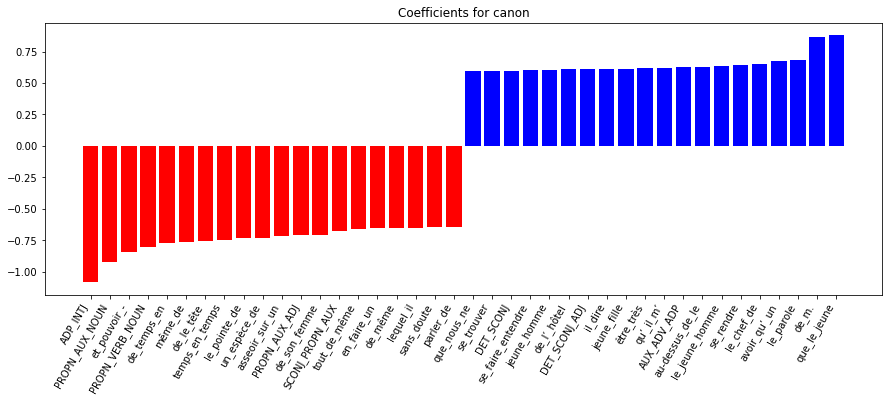

In [260]:
svm_6 = train_svm(df_train_balanced_tout_sauf_unigram, df_test_balanced_tout_sauf_unigram, norms=True, kernel="LinearSVC", final_pred=True, get_coefs=True)

In [8]:
df_main_ones = pd.read_csv(r'data\df_main_ones.csv')
df_main_ones.rename(columns = {'Unnamed: 0':'index'}, inplace = True)
df_main_ones.set_index("index", inplace = True)
df_main_ones = df_main_ones.replace(np.nan, 0)

In [13]:
df_train_ones = df_main_ones.head(107)
df_test_ones = df_main_ones.tail(27)

In [14]:
svm_6 = train_svm(df_train_ones, df_test_ones, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       canon       0.89      0.53      0.67        15
   non_canon       0.61      0.92      0.73        12

    accuracy                           0.70        27
   macro avg       0.75      0.72      0.70        27
weighted avg       0.77      0.70      0.70        27



In [20]:
df_fabula_ones = pd.read_csv(r'data\df_fabula_ones.csv')
df_fabula_ones.rename(columns = {'Unnamed: 0':'index'}, inplace = True)
df_fabula_ones.set_index('index', inplace = True)
df_fabula_ones = df_fabula_ones.replace(np.nan, 0)

In [25]:
df_fabula_train_ones = df_fabula_ones.head(315)
df_fabula_test_ones = df_fabula_ones.tail(79)

In [26]:
svm_6 = train_svm(df_fabula_train_ones, df_fabula_test_ones, norms=True, kernel="LinearSVC", final_pred=False, get_coefs=False)

.......... Formatting data ........
.......... Creating pipeline according to user choices ........
.......... using normalisations ........
.......... choosing SVM ........
.......... Creating pipeline with steps ........
[('scaler', StandardScaler()), ('normalizer', Normalizer()), ('model', LinearSVC())]
              precision    recall  f1-score   support

       False       0.78      0.80      0.79        50
        True       0.64      0.62      0.63        29

    accuracy                           0.73        79
   macro avg       0.71      0.71      0.71        79
weighted avg       0.73      0.73      0.73        79

